# Dataset Description

Download the dataset using following API command - `kaggle competitions download -c imaterialist-challenge-fashion-2018`

In [4]:
from IPython.core.display import HTML
from IPython.display import Image
import json
from plotly.offline import init_notebook_mode, iplot
import matplotlib.pyplot as plt
import plotly.graph_objs as go

from plotly import tools
import seaborn as sns
from PIL import Image

import tensorflow as tf
import numpy as np

init_notebook_mode(connected=True)
%matplotlib inline

In [5]:
train_path = 'imaterialist-challenge-fashion-2018/train.json'
test_path = 'imaterialist-challenge-fashion-2018/test.json'
valid_path = 'imaterialist-challenge-fashion-2018/validation.json'

train_inp = open(train_path).read()
train_inp = json.loads(train_inp)

test_inp = open(test_path).read()
test_inp = json.loads(test_inp)

valid_inp = open(valid_path).read()
valid_inp = json.loads(valid_inp)

# 1. Descriptive Statistics

## 1.1 How many different images there are in the dataset

In [6]:
# how many images 
def get_stats(data):
    total_images = len(data['images'])

    all_annotations = []
    if 'annotations' in data:
        for each in data['annotations']:
            all_annotations.extend(each['labelId'])
    total_labels = len(set(all_annotations))
    return total_images, total_labels, all_annotations

total_images, total_labels, train_annotations = get_stats(train_inp)
print ("Total Images in the train:", total_images)
print ("Total Labels in the train:", total_labels)
print ("")

total_images, total_labels, test_annotations = get_stats(test_inp)
print ("Total Images in the test:", total_images)
print ("Total Labels in the test:", total_labels)
print ("")

total_images, total_labels, valid_annotations = get_stats(valid_inp)
print ("Total Images in the valid:", total_images)
print ("Total Labels in the valid:", total_labels)

Total Images in the train: 1014544
Total Labels in the train: 228

Total Images in the test: 39706
Total Labels in the test: 0

Total Images in the valid: 9897
Total Labels in the valid: 225


There are about 1M images provided in the train dataset and there are 228 distinct labels which are used to label these images.

## 1.2 What is the event rate in dataset ?

In [7]:
from collections import Counter

train_labels = Counter(train_annotations)

xvalues = list(train_labels.keys())
yvalues = list(train_labels.values())

trace1 = go.Bar(x=xvalues, y=yvalues, opacity=0.8, name="year count", marker=dict(color='rgba(20, 20, 20, 1)'))
layout = dict(width=800, title='Distribution of different labels in the train dataset', legend=dict(orientation="h"));

fig = go.Figure(data=[trace1], layout=layout);
iplot(fig);

In [8]:
valid_labels = Counter(valid_annotations)

xvalues = list(valid_labels.keys())
yvalues = list(valid_labels.values())

trace1 = go.Bar(x=xvalues, y=yvalues, opacity=0.8, name="year count", marker=dict(color='rgba(20, 20, 20, 1)'))
layout = dict(width=800, title='Distribution of different labels in the validation dataset', legend=dict(orientation="h"));

fig = go.Figure(data=[trace1], layout=layout);
iplot(fig);

In [9]:
def get_images_for_labels(labellist, data):
    image_ids = []
    for each in data['annotations']:
        if all(x in each['labelId'] for x in labellist):
            image_ids.append(each['imageId'])
            if len(image_ids) == 2:
                break
    image_urls = []
    for each in data['images']:
        if each['imageId'] in image_ids:
            image_urls.append(each['url'])
    return image_urls

In [10]:
temps = train_labels.most_common(10)
labels_tr = ["Label-"+str(x[0]) for x in temps]
values = [x[1] for x in temps]

trace1 = go.Bar(x=labels_tr, y=values, opacity=0.7, name="year count", marker=dict(color='rgba(120, 120, 120, 0.8)'))
layout = dict(height=400, title='Top 10 Labels in the train dataset', legend=dict(orientation="h"));

fig = go.Figure(data=[trace1], layout=layout);
iplot(fig);

Label-66 is the most used label with close to 800k examples

In [11]:
temps = valid_labels.most_common(10)
labels_vl = ["Label-"+str(x[0]) for x in temps]
values = [x[1] for x in temps]

trace1 = go.Bar(x=labels_vl, y=values, opacity=0.7, name="year count", marker=dict(color='rgba(120, 120, 120, 0.8)'))
layout = dict(height=400, title='Top 10 Labels in the valid dataset', legend=dict(orientation="h"));

fig = go.Figure(data=[trace1], layout=layout);
iplot(fig);

Similar distribution for validation set as well

## 1.3 Since the dataset has multiple labels for each image we try to identify the most common co-occuring labels in the dataset

In [12]:
# Most Commonly Occuring Labels 

def cartesian_reduct(alist):
    results = []
    for x in alist:
        for y in alist:
            if x == y:
                continue
            srtd = sorted([int(x),int(y)])
            srtd = " AND ".join([str(x) for x in srtd])
            results.append(srtd)
    return results 

co_occurance = []
for i, each in enumerate(train_inp['annotations']):
    prods = cartesian_reduct(each['labelId'])
    co_occurance.extend(prods)

In [13]:
coocur = Counter(co_occurance).most_common(10)
labels = list(reversed(["Label: "+str(x[0]) for x in coocur]))
values = list(reversed([x[1] for x in coocur]))

trace1 = go.Bar(x=values, y=labels, opacity=0.7, orientation="h", name="year count", marker=dict(color='rgba(130, 130, 230, 0.8)'))
layout = dict(height=400, title='Most Common Co-Occuring Labels in the dataset', legend=dict(orientation="h"));

fig = go.Figure(data=[trace1], layout=layout);
iplot(fig);

Seems like 66, 105, 153 have been used repeatedly in many examples in the dataset

## 1.4 Which images are tagged with most number of labels

In [14]:
def get_image_url(imgid, data):
    for each in data['images']:
        if each['imageId'] == imgid:
            return each['url']

srtedlist = sorted(train_inp['annotations'], key=lambda d: len(d['labelId']), reverse=True)

In [15]:
# TOP-5 Images with most number of labels
for img in srtedlist[:5]:
    iurl = get_image_url(img['imageId'], train_inp)  
    labelpair = ", ".join(img['labelId'])
    imghtml = """Labels: """+ str(labelpair) +""" &nbsp;&nbsp; <b>Total Labels: """+ str(len(img['labelId'])) + """</b><br>""" + "<img src="+iurl+" width=200px; style='float:left'>"
    display(HTML(imghtml))

In [16]:
# How many images have single label
for img in srtedlist[-5:]:
    iurl = get_image_url(img['imageId'], train_inp)  
    labelpair = ", ".join(img['labelId'])
    imghtml = """<b> Label: """+ str(labelpair) +"""</b><br>""" + "<img src="+iurl+" width=200px; height=200px; style='float:left'>"
    display(HTML(imghtml))

## 1.6 Distribution of images with respective label count

In [17]:
lbldst = Counter([len(x['labelId']) for x in srtedlist])

labels = list(lbldst.keys())
values = list(lbldst.values())

trace1 = go.Bar(x=labels, y=values, opacity=0.7, name="year count", marker=dict(color='rgba(10, 80, 190, 0.8)'))
layout = dict(height=400, title='Frequency distribution of images with respective labels counts ', legend=dict(orientation="h"));

fig = go.Figure(data=[trace1], layout=layout);
iplot(fig);

Most of the images have 5-6 labels

# 2. Color of the images

In the e-commerce industry, colors play a very important role in the customer behaviours. Some people are more inclined towards soft colors while some prefer warm colors. In this section, lets visualize what type of colors are present in the images.

## 2.1 Common average color of the images

In [18]:
import urllib
from io import StringIO

def compute_average_image_color(img):
    width, height = img.size
    count, r_total, g_total, b_total = 0, 0, 0, 0
    for x in range(0, width):
        for y in range(0, height):
            r, g, b = img.getpixel((x,y))
            r_total += r
            g_total += g
            b_total += b
            count += 1
    return (r_total/count, g_total/count, b_total/count)

In [19]:
import os 
imgpath = 'top_images/'
read_from_disk = False

if read_from_disk:
    srtedlist = os.listdir(imgpath)
else:
    srtedlist = sorted(train_inp['annotations'], key=lambda d: len(d['labelId']), reverse=True)

In [20]:
import io

average_colors = {}
for img in srtedlist[:10]:
    if read_from_disk:
        img = Image.open(imgpath + img)
    else:
        iurli = get_image_url(img['imageId'], train_inp)
        
        # download the images 
        filename = iurli.split("/")[-1].split("-large")[0]
        urllib.request.urlretrieve(iurli, "top_images/"+filename)
        
        file = io.BytesIO(urllib.request.urlopen(iurli).read())
        img = Image.open(file)
           
    average_color = compute_average_image_color(img)
    if average_color not in average_colors:
        average_colors[average_color] = 0
    average_colors[average_color] += 1

In [21]:
for average_color in average_colors:
    average_color1 = (int(average_color[0]),int(average_color[1]),int(average_color[2]))
    image_url = "<span style='display:inline-block; min-width:200px; background-color:rgb"+str(average_color1)+";padding:10px 10px;'>"+str(average_color1)+"</span>"
    print(image_url)
    display(HTML(image_url))

<span style='display:inline-block; min-width:200px; background-color:rgb(95, 92, 94);padding:10px 10px;'>(95, 92, 94)</span>


<span style='display:inline-block; min-width:200px; background-color:rgb(116, 116, 117);padding:10px 10px;'>(116, 116, 117)</span>


<span style='display:inline-block; min-width:200px; background-color:rgb(103, 81, 82);padding:10px 10px;'>(103, 81, 82)</span>


<span style='display:inline-block; min-width:200px; background-color:rgb(106, 110, 110);padding:10px 10px;'>(106, 110, 110)</span>


<span style='display:inline-block; min-width:200px; background-color:rgb(103, 102, 120);padding:10px 10px;'>(103, 102, 120)</span>


<span style='display:inline-block; min-width:200px; background-color:rgb(132, 127, 124);padding:10px 10px;'>(132, 127, 124)</span>


<span style='display:inline-block; min-width:200px; background-color:rgb(92, 99, 94);padding:10px 10px;'>(92, 99, 94)</span>


<span style='display:inline-block; min-width:200px; background-color:rgb(149, 149, 157);padding:10px 10px;'>(149, 149, 157)</span>


<span style='display:inline-block; min-width:200px; background-color:rgb(94, 87, 90);padding:10px 10px;'>(94, 87, 90)</span>


<span style='display:inline-block; min-width:200px; background-color:rgb(111, 109, 121);padding:10px 10px;'>(111, 109, 121)</span>


## 2.2 Most dominant color in the images

In [22]:
!pip install colorthief

In [23]:
# top used colors in images 
from colorthief import ColorThief

pallets = []
for img in srtedlist[:10]:
    
    file=None
    if read_from_disk:
        img = imgpath + img
    else:
        iurli = get_image_url(img['imageId'], train_inp)
        
        # download the images 
        filename = iurli.split("/")[-1].split("-large")[0]
        urllib.request.urlretrieve(iurli, "top_images/"+filename)
        
        file = io.BytesIO(urllib.request.urlopen(iurli).read())
        img = Image.open(file)

    color_thief = ColorThief(file)
    dominant_color = color_thief.get_color(quality=1)
    
    image_url = "<span style='display:inline-block; min-width:200px; background-color:rgb"+str(dominant_color)+";padding:10px 10px;'>"+str(dominant_color)+"</span>"
    display(HTML(image_url))
    
    palette = color_thief.get_palette(color_count=6)
    pallets.append(palette)

## 2.3 Common color pallets of the images

In [24]:
for pallet in pallets:
    img_url = ""
    for pall in pallet:
        img_url += "<span style='background-color:rgb"+str(pall)+";padding:20px 10px;'>"+str(pall)+"</span>"
    img_url += "<br>"
    display(HTML(img_url))
    print 

# 3. Building the Object Detection Model

In [25]:
!pip install --user -r tensorflow_models/models/official/requirements.txt

In [26]:
# DOWNLOAD THE UTILS FROM THIS LINK - https://github.com/tensorflow/models/tree/master/research/object_detection/utils
import tarfile

def DOWNLOAD_MODELS():
    MODEL_NAME = 'ssd_mobilenet_v1_coco_2017_11_17'
    MODEL_FILE = MODEL_NAME + '.tar.gz'
    DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'
    PATH_TO_CKPT = MODEL_NAME + '/frozen_inference_graph.pb'
    PATH_TO_LABELS = os.path.join('data', 'mscoco_label_map.pbtxt')
    
    opener = urllib.request.URLopener()
    opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)
    tar_file = tarfile.open(MODEL_FILE)
    for file in tar_file.getmembers():
        file_name = os.path.basename(file.name)
        if 'frozen_inference_graph.pb' in file_name:
            tar_file.extract(file, os.getcwd())

In [27]:
DOWNLOAD_MODELS()

/var/folders/v7/8lds1vw50zz7f250sgzln0hm0000gn/T/ipykernel_22446/680820218.py:1: DeprecationWarning:

URLopener style of invoking requests is deprecated. Use newer urlopen functions/methods



In [28]:
import tensorflow as tf
tf.compat.v1.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [30]:
import sys
sys.path.append('/tensorflow_models/models/research/object_detection')

In [76]:
from object_detection.utils import label_map_util
import cv2

def detect_object(filename, draw_image=False):

    def img2array(img):
        (img_width, img_height) = img.size
        return np.array(img.getdata()).reshape((img_width, img_height, 3)).astype(np.uint8)

    categories, probabilities = [], []
    PATH_TO_CKPT = 'ssd_mobilenet_v1_coco_2017_11_17/frozen_inference_graph.pb'
    PATH_TO_LABELS = os.path.join('tensorflow_models/models/research/object_detection/data/',
                                  'mscoco_label_map.pbtxt')
    detection_graph = tf.Graph()
    with detection_graph.as_default():
        od_graph_def = tf.compat.v1.GraphDef()
        with tf.compat.v2.io.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
            serialized_graph = fid.read()
            od_graph_def.ParseFromString(serialized_graph)
            tf.import_graph_def(od_graph_def, name='')


    label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
    
    categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=100, use_display_name=True)
    category_index = label_map_util.create_category_index(categories)

    with detection_graph.as_default():
        with tf.compat.v1.Session(graph=detection_graph) as sess:
            image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
            detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
            detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
            detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
            num_detections = detection_graph.get_tensor_by_name('num_detections:0')

            image = Image.open(filename)
            image_np = img2array(image)
            image_np_expanded = np.expand_dims(image_np, axis=0)
            (boxes, scores, classes, num) = sess.run([detection_boxes, detection_scores, detection_classes, num_detections], feed_dict={image_tensor: image_np_expanded})
            
            for index, value in enumerate(classes[0]):
                if float(scores[0, index]) > 0.1:
                    temp = category_index.get(value)['name']
                    if temp not in categories:
                        categories.append(temp)
                        probabilities.append(scores[0, index])
                        
            if draw_image:
                boxes = boxes[0][scores[0] > 0.3]
                colors = np.array([[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]])
                classes = classes[0][scores[0] > 0.3]
                scores = scores[0][scores[0] > 0.3]
                num_detections = len(boxes)
#                 tf_image = tf.image.convert_image_dtype(tf.expand_dims(image_np, axis=0), tf.float32)            
                
#                 drawn_image = tf.image.draw_bounding_boxes(tf_image, boxes.reshape([1, num_detections, 4]), colors)
                
                # OpenCV uses BGR
                width, height, _ = image_np.shape
                
                drawn_image_bgr = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)
                
                # annotate the bounding boxes with class names
                for i, box in enumerate(boxes):
                    ymin, xmin, ymax, xmax = box
                    ymin *= height
                    xmin *= width
                    ymax *= height
                    xmax *= width
                    class_label = classes[i]
                    class_name = category_index.get(class_label)['name']

                    # Draw the bounding box rectangle
                    cv2.rectangle(drawn_image_bgr, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (0, 255, 0), 2)

                    # Annotate with class name
                    annotation = f"{class_name}:{scores[i]:.3f}"
                    cv2.putText(drawn_image_bgr, annotation, (int(xmin), int(ymin - 5)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
                
                
                drawn_image_bgr = cv2.cvtColor(drawn_image_bgr, cv2.COLOR_BGR2RGB)
                plt.imshow(drawn_image_bgr)
                plt.axis('off')
                plt.show()
    return categories, probabilities

2023-07-16 18:46:52.831805: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-07-16 18:46:52.831828: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-07-16 18:46:53.036909: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


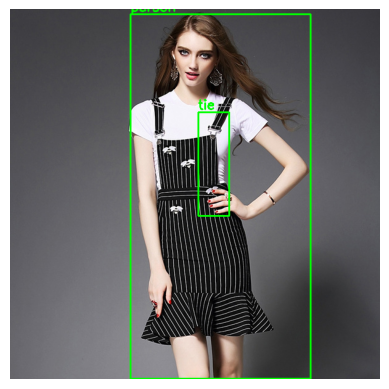

2023-07-16 18:47:36.342117: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-07-16 18:47:36.342165: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-07-16 18:47:36.623572: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


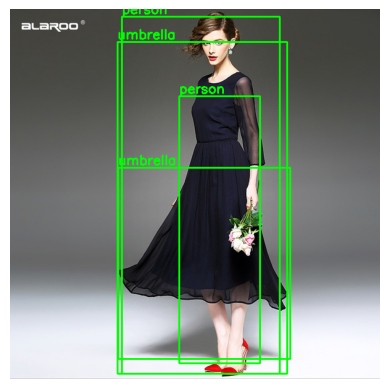

2023-07-16 18:48:12.253233: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-07-16 18:48:12.253270: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-07-16 18:48:12.535429: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


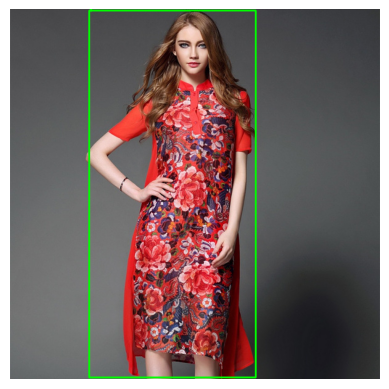

2023-07-16 18:48:49.132191: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-07-16 18:48:49.132231: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-07-16 18:48:49.492623: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


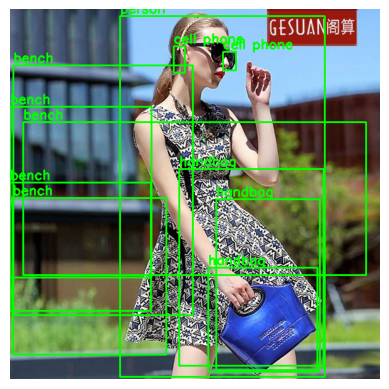

2023-07-16 18:49:25.593571: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-07-16 18:49:25.593603: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-07-16 18:49:25.864403: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


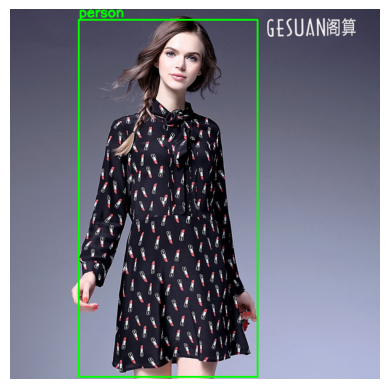

2023-07-16 18:50:04.185453: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-07-16 18:50:04.185478: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-07-16 18:50:04.431181: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


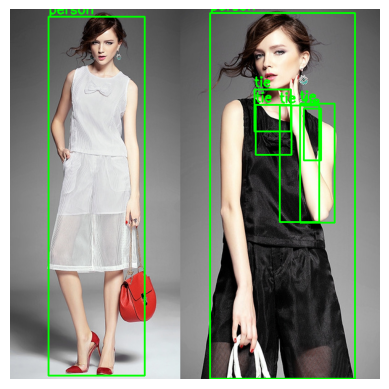

2023-07-16 18:50:50.775969: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-07-16 18:50:50.776001: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-07-16 18:50:51.567284: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


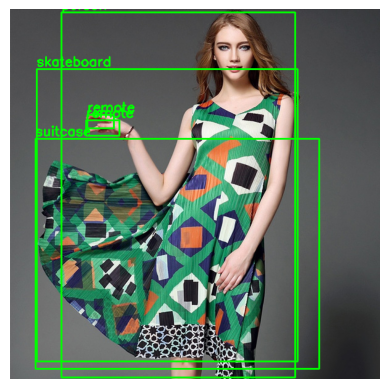

2023-07-16 18:51:32.437825: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-07-16 18:51:32.437851: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-07-16 18:51:32.700744: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


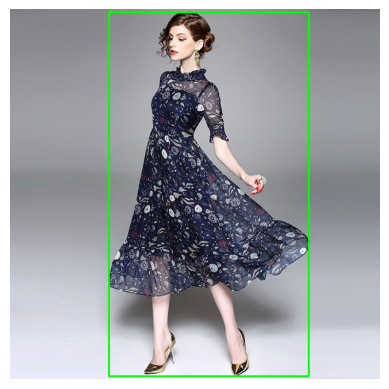

2023-07-16 18:52:11.100314: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-07-16 18:52:11.100339: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-07-16 18:52:11.315446: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


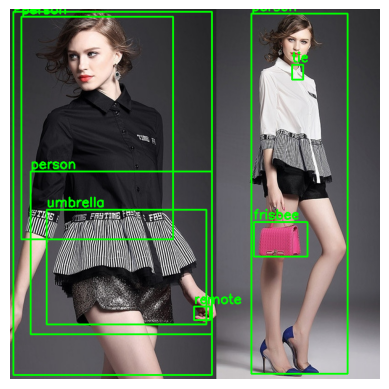

2023-07-16 18:53:15.262978: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-07-16 18:53:15.263022: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-07-16 18:53:15.479031: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


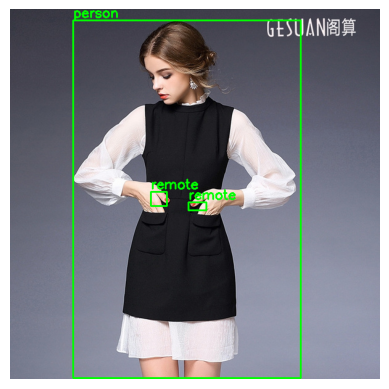

In [77]:
for img in srtedlist[:10]:
    iurli = get_image_url(img['imageId'], train_inp)
    
    file = io.BytesIO(urllib.request.urlopen(iurli).read())
    objects = detect_object(file, draw_image=True)

I neither have time nor the energy to go through all the 228 labels and give a name for them, train a simple YOLO/SSD model, pre-trained models are typically not trained on clothing item so it is better to train one yourself, but the procedure more-or-less remains the same, make sure you conform to the tensorflow_models' API